# <font color='green' style='font-size: 30px;'>Bibliotecas usadas</font>
<hr style='border: 2px solid green;'>

In [296]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics
from glob import glob
import math

%matplotlib inline

In [3]:
sns.set_palette("Accent")
sns.set_style("darkgrid")

# <font color='green' style='font-size: 30px;'>Problema</font>
<hr style='border: 2px solid green;'>

# <font color='gray' style='font-size: 20px;'>Descrição do problema</font>

Você é um funcionário da OMS que deve avaliar os níveis de contaminação de um vírus em um determinado país. As pessoas dentro de uma sociedade podem estar conectadas de alguma maneira (familia, amizade ou trabalho) e cada pessoa possui um conjunto de atributos.

# <font color='gray' style='font-size: 20px;'>Comportamento do vírus</font>

<b>Este vírus afeta esta sociedade como descrito a seguir: </b>

● a taxa de contaminação varia de pessoa para pessoa;

● a taxa de contaminação de uma pessoa A para B é diferente de B para A e depende
das características de ambas as pessoas (A e B);

● a contaminação só passa através de indivíduos conectados;

● não existe cura para essa doença;

# <font color='gray' style='font-size: 20px;'>Desafio</font>

Foram coletados os dados de contaminação (ou seja, as taxas de contaminação) para metade desta sociedade. Neste problema, você deverá estimar a taxa para o restante dessa sociedade
e decidir políticas de saúde com base nos resultados obtidos.

# <font color='gray' style='font-size: 20px;'>Observação</font>

Para determinar as taxas de contaminação, devem ser levados em consideração tanto as características dos infectados quanto dos infectantes.

# <font color='green' style='font-size: 30px;'>Funções</font>
<hr style='border: 2px solid green;'>

# <font color='green' style='font-size: 20px;'>Preenchendo os dados faltantes pela média correspondente dos valores dos atributos grau e proximidade</font>

In [321]:
def preenchendo_dados_faltantes_prob_V1_V2(df_conexoes):
    df_conexoes['prob_V1_V2'] = df_conexoes['prob_V1_V2'].fillna(df_conexoes.groupby(['grau', 'proximidade'])['prob_V1_V2'].transform('mean'))
    
    return df_conexoes

# <font color='green' style='font-size: 20px;'>Preenchendo dos dados faltantes</font>

# <font color='gray' style='font-size: 15px;'>Preenchendo dos dados faltantes do tipo categorico como 'Desconhecido'</font>

In [101]:
def preenchendo_dados_categoricos(df, colunas):
    for coluna in colunas:
        df[coluna] = df[coluna].fillna('desconhecido')
    
    return df

# <font color='gray' style='font-size: 15px;'>Preenchendo os dados faltantes da idade pela média correspondente do valor da idade por estado_civil</font>

In [350]:
def preenchendo_dados_faltantes_idade(df):
    df['idade'] = df['idade'].fillna(df.groupby('estado_civil')['idade'].transform('mean')).astype(int)
    
    return df

# <font color='gray' style='font-size: 15px;'>Preenchendo os dados faltantes do IMC pela média correspondente se a pessoa é sendetario ou não</font>

In [351]:
def preenchendo_dados_faltantes_IMC(df):
    df['IMC'] = df['IMC'].fillna(df.groupby('pratica_esportes')['IMC'].transform('mean'))
    
    return df

# <font color='gray' style='font-size: 15px;'>Preenchendo os dados faltantes da quantidade de filhos pela média de filhos pelo atributo estado_civil</font>

In [352]:
def preenchendo_dados_faltantes_qt_filhos(df):
    df['qt_filhos'] = df['qt_filhos'].fillna(df.groupby('estado_civil')['qt_filhos'].transform('mean')).astype(int)
    
    return df

# <font color='gray' style='font-size: 15px;'>Tratamento dos dados categóricos</font>

In [353]:
def tratamento_dados_categoricos(df):
    
    cleanup_nums = {"estado_civil": {"solteiro": 0, "casado": 1, "divorciado": 2, "viuvo": 3, "desconhecido": 4},
                   "transporte_mais_utilizado": {"publico": 0, "particular": 1, "taxi": 2, "desconhecido": 3},
                   "estuda": {"desconhecido": 3},
                   "trabalha": {"desconhecido": 3},
                   "pratica_esportes": {"desconhecido": 3}}

    df.replace(cleanup_nums, inplace = True)
    return df

# <font color='green' style='font-size: 20px;'>Verificando dados duplicados</font>

In [158]:
#Limpando dados duplicado do dataset conexoes, deixando apenas a primeira ocorrência
def verificando_removendo_duplicados(df):
    df.drop_duplicates(keep='first', inplace=True) 
    
    return df

# <font color='green' style='font-size: 20px;'>Verificando outliers</font>

In [407]:
#A abordagem de intervalo interquartil IQR (intervalo interquartil) pode ser usada para encontrar valores discrepantes.
#Porém os dados aparenta está ok, pois: podem haver récem nascidos como pessoas de 124 anos, os individuos podem ter 9 filhos, e pode haver individuos com obesidade grau IV (superobesos) com IMC de 89.
def iqr(df, atributo):
    Q1 = np.percentile(df[atributo], 25,
                       interpolation = 'midpoint')

    Q3 = np.percentile(df[atributo], 75,
                       interpolation = 'midpoint')
    IQR = Q3 - Q1

    # Limite superior
    upper = np.where(df[atributo] >= (Q3+1.5*IQR))
    # Limite inferior
    lower = np.where(df[atributo] <= (Q1-1.5*IQR))
    
    return upper, lower

In [409]:
#A abordagem de intervalo interquartil IQR (intervalo interquartil) pode ser usada para encontrar valores discrepantes.
#Porém os dados aparenta está ok, pois: podem haver récem nascidos como pessoas de 124 anos, os individuos podem ter 9 filhos, e pode haver individuos com obesidade grau IV (superobesos) com IMC de 89.
def verificando_outliers(df, colunas):
    outliers = []
    for atributo in colunas:
        upper, lower = iqr(df, atributo)
        if len(upper) + len(lower) > 0:
            outliers.append((atributo, True))
        else:
            outliers.append((atributo, False))
        
    return outliers     


In [410]:
def removendo_outliers(df, colunas):
    for atributo in colunas:
        upper, lower = iqr(df, atributo)

        #Removendo as outliers
        df.drop(upper[0], inplace = True, errors='ignore')
        df.drop(lower[0], inplace = True, errors='ignore')
        
    return df

# <font color='green' style='font-size: 20px;'>Gerando datasets com informações da conexão e características dos indivíduos</font>

# <font color='gray' style='font-size: 15px;'>Criação dos csv do dataset de treino</font>

In [53]:
#Como concatenar todos os dados de uma vez consumia muito tempo, gerando dataset(csv) com dados da conexao e caracteristica dos individuos conectados
#a cada 100000 dados de conexão

def mesclando_dados_individuos_dataset(df_conexoes, df_individuos):
    df_final = pd.DataFrame()
    for i in range(len(df_conexoes)):
        df_specific_conexoes = df_conexoes.iloc[[i]]
        df_v1 = df_individuos.loc[df_individuos['name'] == df_specific_conexoes['V1'][i]]
        df_v2 = df_individuos.loc[df_individuos['name'] == df_specific_conexoes['V2'][i]]
        df_v1.drop(['name'], inplace=True, errors='ignore', axis=1)
        df_v2.drop(['name'], inplace=True, errors='ignore', axis=1)
        df_v1 = df_v1.add_suffix('_V1')
        df_v2 = df_v2.add_suffix('_V2')
        df_rows = pd.concat([df_specific_conexoes.reset_index(drop=True), df_v1.reset_index(drop=True), df_v2.reset_index(drop=True)], axis=1)
        if i % 10000 == 0:
            if i is not 0:
                df_final.to_csv("datasets/merge_dataset_{}.csv".format(i), index = False)
                print("Progresso: " + str(i / 10000) + "%")
            df_final = df_rows
        else:
            df_final = pd.concat([df_final.reset_index(drop=True), df_rows.reset_index(drop=True)])
            
    df_final.to_csv("datasets/merge_dataset_final.csv", index = False)


# <font color='gray' style='font-size: 15px;'>Concatenando todos os csv para gerar dataset de treino</font>

In [38]:
#mesclando os CSVs em um único CSV
def merge_csv_dataset_concatenados():
    data = []
    filenames = glob('datasets/*.csv')
    for filename in filenames:
        data.append(pd.read_csv(filename, sep=','))
        
    all_data = pd.concat(data)

    return all_data               

# <font color='gray' style='font-size: 15px;'>Gerando o dataset de teste</font>

In [49]:
#Gerando dataset a ser realizado as estimativas
def gerando_dataset_teste(df_merge):
    #df_conexoes = df_merge[['V1', 'V2', 'grau', 'proximidade', 'prob_V1_V2']]
    #df_v1 = df_merge[['idade_V1', 'estado_civil_V1', 'qt_filhos_V1', 'estuda_V1', 'trabalha_V1', 'pratica_esportes_V1', 'transporte_mais_utilizado_V1', 'IMC_V1']]
    #df_v2 = df_merge[['idade_V2', 'estado_civil_V2', 'qt_filhos_V2', 'estuda_V2', 'trabalha_V2', 'pratica_esportes_V2', 'transporte_mais_utilizado_V2', 'IMC_V2']]
    
    #Mover colunas
    mudar_colunas = ['V2', 'V1', 'grau', 'proximidade', 'prob_V1_V2', 'idade_V2', 'estado_civil_V2', 'qt_filhos_V2', 'estuda_V2', 'trabalha_V2', 'pratica_esportes_V2', 'transporte_mais_utilizado_V2', 'IMC_V2',
                    'idade_V1', 'estado_civil_V1', 'qt_filhos_V1', 'estuda_V1', 'trabalha_V1', 'pratica_esportes_V1', 'transporte_mais_utilizado_V1', 'IMC_V1']
    df_merge_teste = df_merge[mudar_colunas]
    
    #Renomear colunas
    df_merge_teste.rename(columns = {'V2':'V1', 'V1':'V2', 'idade_V2':'idade_V1', 'estado_civil_V2': 'estado_civil_V1', 'qt_filhos_V2': 'qt_filhos_V1', 'estuda_V2': 'estuda_V1', 'trabalha_V2': 'trabalha_V1', 
                                    'pratica_esportes_V2': 'pratica_esportes_V1', 'transporte_mais_utilizado_V2':'transporte_mais_utilizado_V1', 'IMC_V2':'IMC_V1', 'idade_V1':'idade_V2', 
                                     'estado_civil_V1': 'estado_civil_V2', 'qt_filhos_V1': 'qt_filhos_V2', 'estuda_V1': 'estuda_V2', 'trabalha_V1': 'trabalha_V2', 'pratica_esportes_V1': 'pratica_esportes_V2', 
                                     'transporte_mais_utilizado_V1':'transporte_mais_utilizado_V2', 'IMC_V1':'IMC_V2'}, inplace = True)
    #or
    #df=df.reindex(columns=new_cols)
    return df_merge_teste

# <font color='green' style='font-size: 20px;'>Estimando taxa de contaminação</font>

In [376]:
def estimando_taxa_contaminacao(X_treino, X_teste, y_treino, y_teste):
    # Criar objeto de regressão linear
    reg = linear_model.LinearRegression()

    # Treinar o modelo usando os conjuntos de treinamento
    reg.fit(X_treino, y_treino)
    
    # Treinar o modelo usando os conjuntos de treinamento
    y_pred = reg.predict(X_teste)
    
    return y_pred

# <font color='green' style='font-size: 30px;'>Analisando os dados</font>
<hr style='border: 2px solid green;'>

# <font color='green' style='font-size: 20px;'>Analisando dataset de conexões</font>

In [381]:
df_conexoes = pd.read_csv('data/conexoes_espec.csv', sep=';')
df_conexoes.head()

,V1,V2,grau,proximidade,prob_V1_V2
0,1,2,trabalho,visita_frequente,0.589462
1,1,3,trabalho,visita_rara,0.708465
2,2,4,trabalho,visita_casual,NaN
3,2,5,trabalho,visita_rara,0.638842
4,3,6,amigos,mora_junto,NaN


In [383]:
df_conexoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   V1           999999 non-null  int64  
 1   V2           999999 non-null  int64  
 2   grau         999999 non-null  object 
 3   proximidade  999999 non-null  object 
 4   prob_V1_V2   499999 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 38.1+ MB


In [411]:
colunas_conexoes = ['prob_V1_V2']
outliers_conexoes = verificando_outliers(df_conexoes, colunas_conexoes)
print(outliers_conexoes)

[('prob_V1_V2', True)]


# <font color='gray' style='font-size: 15px;'>Observando a descrição para analisar os possíveis outliers</font>

In [21]:
#Observando a descrição do dataframe conexões, não aparentar ter outliers
#Taxa de contaminação entre 0.074462 e 0.942245
df_conexoes.describe(include='all')

,V1,V2,grau,proximidade,prob_V1_V2
count,999999.000000,999999.000000,999999,999999,999999.000000
unique,NaN,NaN,3,4,NaN
top,NaN,NaN,trabalho,visita_rara,NaN
freq,NaN,NaN,333548,400238,NaN
mean,250000.250000,500001.000000,NaN,NaN,0.485012
std,144337.495129,288674.990257,NaN,NaN,0.140295
min,1.000000,2.000000,NaN,NaN,0.074462
25%,125000.500000,250001.500000,NaN,NaN,0.385877
50%,250000.000000,500001.000000,NaN,NaN,0.505482
75%,375000.000000,750000.500000,NaN,NaN,0.562713


In [384]:
#Verificando se há valores nulos no dataframe
print ('Quantidade de dados nulos \n', df_conexoes.isna().sum())

Quantidade de dados nulos 
 V1                  0
V2                  0
grau                0
proximidade         0
prob_V1_V2     500000
dtype: int64


# <font color='green' style='font-size: 20px;'>Analisando dataset de individuos</font>

In [385]:
df_individuos = pd.read_csv('data/individuos_espec.csv', sep=';')

In [386]:
df_individuos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   name                       1000000 non-null  int64  
 1   idade                      904063 non-null   float64
 2   estado_civil               949927 non-null   object 
 3   qt_filhos                  971133 non-null   float64
 4   estuda                     959870 non-null   float64
 5   trabalha                   993647 non-null   float64
 6   pratica_esportes           850876 non-null   float64
 7   transporte_mais_utilizado  956967 non-null   object 
 8   IMC                        886130 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 68.7+ MB


In [412]:
colunas_individuos = ['idade', 'qt_filhos', 'IMC']
outliers_individuos = verificando_outliers(df_individuos, colunas_individuos)
print(outliers_individuos)

[('idade', True), ('qt_filhos', True), ('IMC', True)]


# <font color='gray' style='font-size: 15px;'>Observando a descrição para analisar os possíveis outliers</font>

In [394]:
#Observando a descrição do dataframe individuos:

#Idade: pode ter recém nascido (0 anos) e a pessoa mais velha do mundo registrada tinha a idade de 122 anos. Mas, ano passado (2021), um homem de 127 anos pode ter sido a pessoa mais velha do mundo.
#Fonte: https://www.ebiografia.com/pessoa_mais_velha_do_mundo/
#Fonte: https://aventurasnahistoria.uol.com.br/noticias/historia-hoje/homem-que-morreu-aos-127-anos-pode-quebrar-recorde-de-pessoa-mais-velha-do-mundo.phtml
#Valores podem está ok

#qt_filhos: pessoas podem ter nenhum filho como podem ter 9.
#Valores podem está ok

#Jon Brower foi o ser humano mais pesado da história, com um peso de aproximadamente 634 kg e tinha a altura de 1,85, gerando um IMC de 185.2.
#Fonte: https://top10mais.org/top-10-pessoas-mais-pesadas-do-mundo/
#Valores podem está ok
df_individuos.describe(include='all')

,name,idade,estado_civil,qt_filhos,estuda,trabalha,pratica_esportes,transporte_mais_utilizado,IMC
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,886130.000000
mean,500000.500000,29.972806,1.082048,0.914406,0.545217,0.572261,0.957747,0.559387,22.472079
std,288675.278932,10.423375,1.180441,0.989744,0.699096,0.531880,0.967064,0.775159,7.073692
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.852828
25%,250000.750000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.420851
50%,500000.500000,29.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,21.431200
75%,750000.250000,36.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,26.378197
max,1000000.000000,124.000000,4.000000,9.000000,3.000000,3.000000,3.000000,3.000000,89.158204


In [389]:
#Verificando se há valores nulos no dataframe
print ('Quantidade de dados nulos \n', df_individuos.isna().sum())

Quantidade de dados nulos 
 name                              0
idade                         95937
estado_civil                  50073
qt_filhos                     28867
estuda                        40130
trabalha                       6353
pratica_esportes             149124
transporte_mais_utilizado     43033
IMC                          113870
dtype: int64


# <font color='green' style='font-size: 30px;'>Principal</font>
<hr style='border: 2px solid green;'>

# <font color='gray' style='font-size: 20px;'>Aplicando tratamento dos dados faltosos nos datasets</font>

In [391]:
df_conexoes = preenchendo_dados_faltantes_prob_V1_V2(df_conexoes)

In [392]:
colunas_categoricas = ['estado_civil', 'estuda', 'trabalha', 'pratica_esportes', 'transporte_mais_utilizado']

df_individuos = preenchendo_dados_categoricos(df_individuos, colunas_categoricas)
df_individuos = preenchendo_dados_faltantes_idade(df_individuos)
df_individuos = preenchendo_dados_faltantes_qt_filhos(df_individuos)
df_individuos = tratamento_dados_categoricos(df_individuos)

# <font color='gray' style='font-size: 20px;'>Verificando dados duplicados nos datasets</font>

In [393]:
df_conexoes = verificando_removendo_duplicados(df_conexoes)
df_individuos = verificando_removendo_duplicados(df_individuos)

In [ ]:
mesclando_dados_individuos_dataset(df_conexoes, df_individuos)

In [ ]:
datasets_train = merge_csv_dataset_concatenados()
datasets_train.to_csv("data/datasets_train.csv", index = False)
datasets_train

In [126]:
datasets_test = gerando_dataset_teste(datasets)
datasets_test.loc[:, "prob_V1_V2"] = np.nan
datasets_test.to_csv("data/datasets_test.csv", index = False)
datasets_test

,V1,V2,grau,proximidade,prob_V1_V2,idade_V1,estado_civil_V1,qt_filhos_V1,estuda_V1,trabalha_V1,...,transporte_mais_utilizado_V1,IMC_V1,idade_V2,estado_civil_V2,qt_filhos_V2,estuda_V2,trabalha_V2,pratica_esportes_V2,transporte_mais_utilizado_V2,IMC_V2
0,2.0,1,trabalho,visita_frequente,NaN,24.0,casado,0.0,0.0,0.0,...,publico,25.378720,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956
1,3.0,1,trabalho,visita_rara,NaN,35.0,solteiro,1.0,0.0,0.0,...,particular,19.952393,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956
2,4.0,2,trabalho,visita_casual,NaN,50.0,casado,1.0,1.0,1.0,...,publico,26.732053,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720
3,5.0,2,trabalho,visita_rara,NaN,30.0,solteiro,2.0,1.0,0.0,...,publico,15.295668,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720
4,6.0,3,amigos,mora_junto,NaN,20.0,NaN,1.0,0.0,1.0,...,publico,20.412942,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,999996.0,499998,trabalho,visita_rara,NaN,34.0,casado,1.0,0.0,1.0,...,publico,17.556771,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885
99995,999997.0,499998,trabalho,visita_rara,NaN,40.0,casado,1.0,0.0,1.0,...,particular,24.848402,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885
99996,999998.0,499999,familia,visita_casual,NaN,30.0,divorciado,1.0,0.0,0.0,...,publico,NaN,26.0,casado,3.0,0.0,0.0,0.0,taxi,19.543889
99997,999999.0,499999,familia,visita_rara,NaN,33.0,casado,0.0,1.0,1.0,...,publico,16.979569,26.0,casado,3.0,0.0,0.0,0.0,taxi,19.543889


# <font color='green' style='font-size: 30px;'>Estimando a taxa de contaminação para o restante da sociedade</font>
<hr style='border: 2px solid green;'>

In [374]:
datasets_train = pd.read_csv('data/datasets_train.csv', sep=',')

In [375]:
datasets_test = pd.read_csv('data/datasets_test.csv', sep=',')

In [377]:
y_treino = datasets_train['prob_V1_V2']
#Considerando apenas as características dos indivíduos
X_treino = datasets_train.drop(columns=['V1', 'V2', 'grau', 'proximidade', 'prob_V1_V2'])
X_teste = datasets_test.drop(columns=['V1', 'V2', 'grau', 'proximidade', 'prob_V1_V2'])

In [379]:
y_predito = estimando_taxa_contaminacao(X_treino, X_teste, y_treino, y_teste)

In [380]:
y_predito

array([0.50615066, 0.4993669 , 0.44739877, ..., 0.54405653, 0.49251692,
       0.47394985])

# <font color='green' style='font-size: 30px;'>Analisando Redes de Grafos de contaminação para um subconjunto</font>
<hr style='border: 2px solid green;'>

# <font color='gray' style='font-size: 20px;'>Usando método de cascata independente</font>

Cascata independente: Um dos modelos básicos populares frequentemente usados para descrever o processo de informações, como por exemplo disseminação viral. 

No modelo Cascata Independente, cada um dos vizinhos ativos do nó tem uma chance probabilística e independente de ativar o nó. Esse problema se assemelha ao desafio, onde cada uma das interações sociais pode desencadear a contaminação pelo vírus.

In [219]:
def generate_nodes(sub_df_conexoes):
    nodes_v1 = sub_df_conexoes['V1'].unique()
    nodes_v2 = sub_df_conexoes['V2'].unique()
    nodes_v1_v2 = list(itertools.chain(nodes_v1,nodes_v2))
    nodes = list(set(nodes_v1_v2)) 
    
    return nodes

In [220]:
def inicializando_grafo(sub_df_conexoes):
    G = nx.Graph()
    nodes = generate_nodes(sub_df_conexoes)
    G.add_nodes_from(nodes)
    
    df_conexoes_arestas = sub_df_conexoes.loc[(sub_df_conexoes['V1'].isin(nodes)) & (sub_df_conexoes['V2'].isin(nodes))]
    for row in df_conexoes_arestas.iterrows():
        G.add_edge(row[1]['V1'], row[1]['V2'], weight=row[1]['prob_V1_V2'])
        
    weighted_degrees = dict(nx.degree(G,weight='weight'))
    pos = nx.spring_layout(G,weight='weight',iterations=10, k = 4)
    
    return G, weighted_degrees, pos

In [210]:
G, weighted_degrees, pos = inicializando_grafo(sub_df_conexoes)

In [211]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 101
Number of edges: 100
Average degree:   1.9802


In [224]:
def cascata_independente(G, t, tempo_contaminacao):
    #fazendo um passo t->t+1 da simulação
    #cada nó contaminado infecta vizinhos com probabilidade proporcional ao peso
    max_weight = max([e[2]['weight'] for e in G.edges(data=True)])
    atual_contaminado = [n for n in tempo_contaminacao if tempo_contaminacao[n]==t]
    for n in atual_contaminado:
        for v in G.neighbors(n):
            if v not in tempo_contaminacao:
                if  G.get_edge_data(n,v)['weight'] >= np.random.random()*max_weight:
                    tempo_contaminacao[v] = t + 1
    return tempo_contaminacao

In [229]:
def plot_G(G, pos, weighted_degrees, tempo_contaminacao, t):
    
    atual_contaminado = [n for n in tempo_contaminacao if tempo_contaminacao[n] == t]
    
    plt.figure()
    plt.axis('off')
    plt.title('Rede de contaminação, t={}'.format(t),fontsize = 24)

    for node in G.nodes():
        size = 1000 * weighted_degrees[node]
        if node in atual_contaminado:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#feba02')
        elif tempo_contaminacao.get(node,9999999)<t:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#ff0000')
        else:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#009fe3')
        ns.set_edgecolor('#f2f6fa')
    nx.draw_networkx_labels(G,pos,{n : n for n in G.nodes() if weighted_degrees[n]>0.0}, font_size=10);

    for e in G.edges(data=True):
        if e[2]['weight'] > 0.0:
            nx.draw_networkx_edges(G, pos, [e], width=e[2]['weight'], edge_color='#707070')

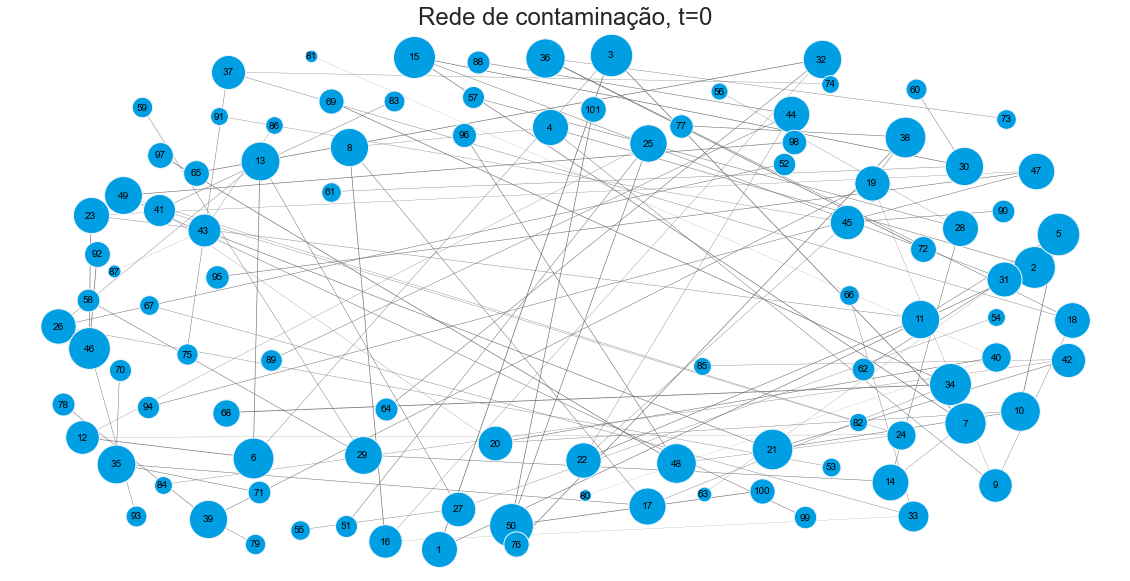

In [231]:
tempo_contaminacao = {}
t = 0
plot_G(G, pos, weighted_degrees, tempo_contaminacao, t)

# <font color='gray' style='font-size: 20px;'>Simulando uma cascata independente</font>

In [237]:
#Iniciando uma simulação onde no dataset conexões aponta que o individuo 1 estava contaminado e teve contato com os individuos 2 e 3

tempo_contaminacao = {1:-1,2:0,3:0}

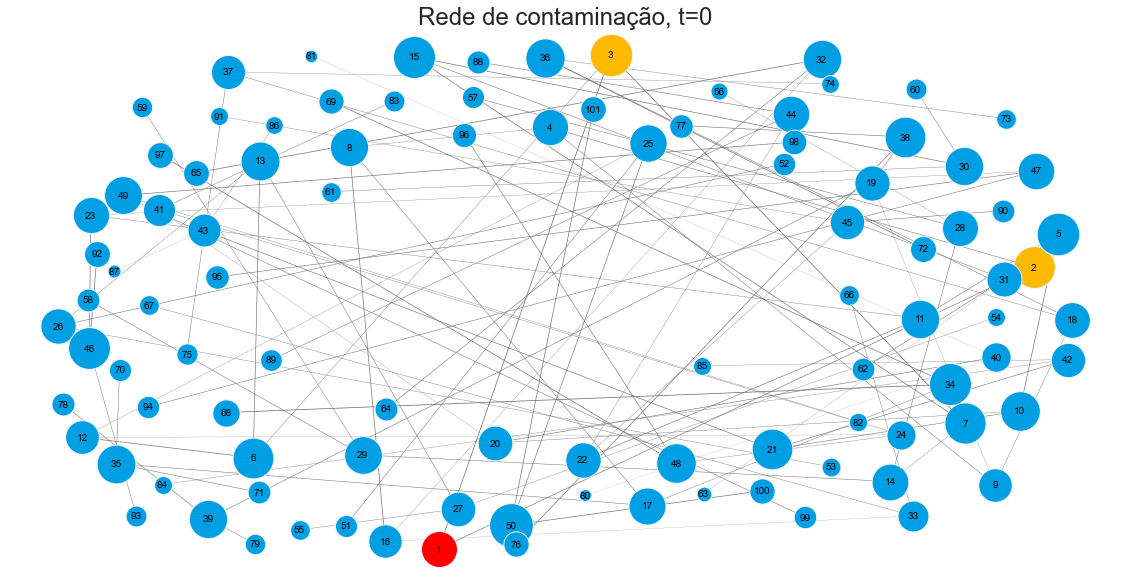

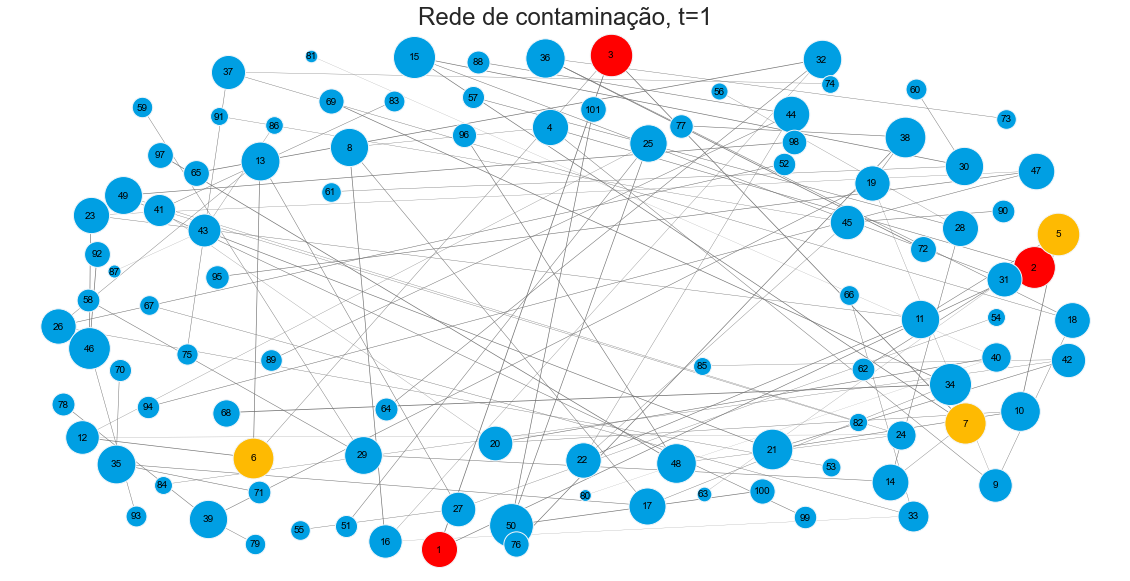

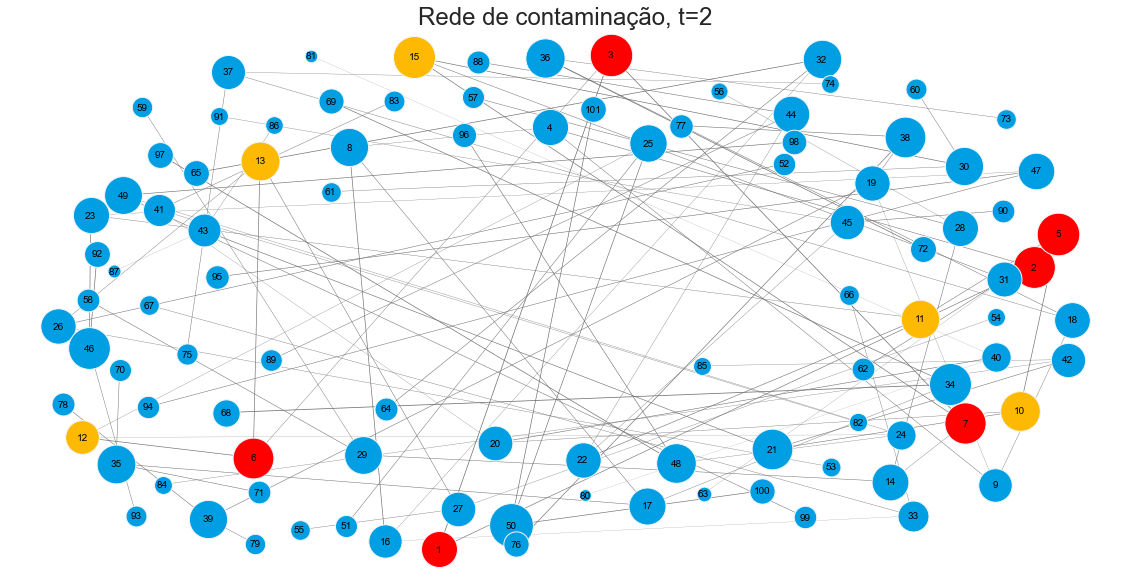

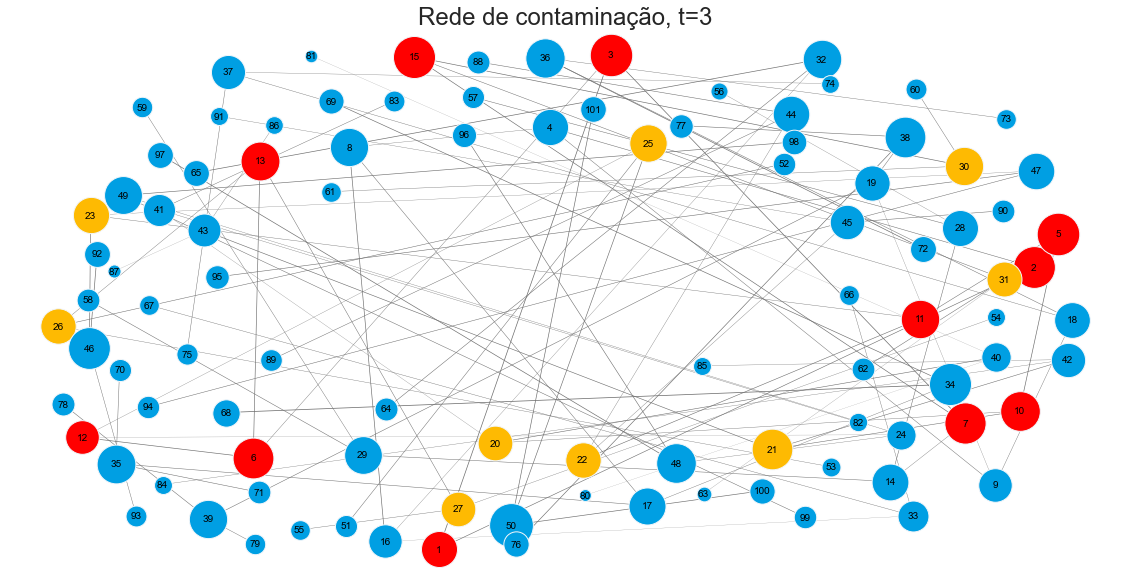

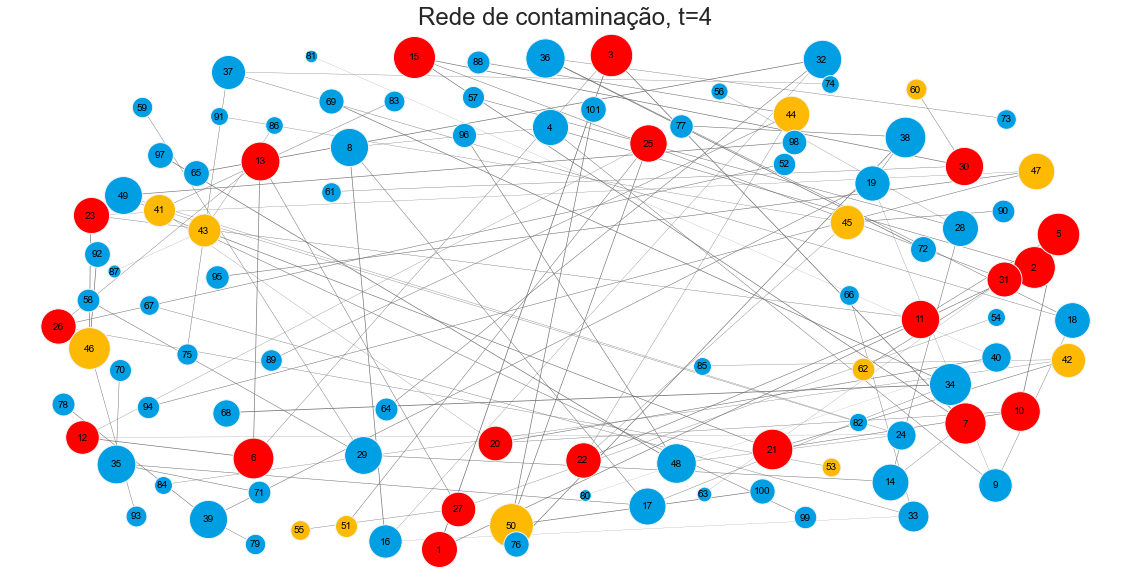

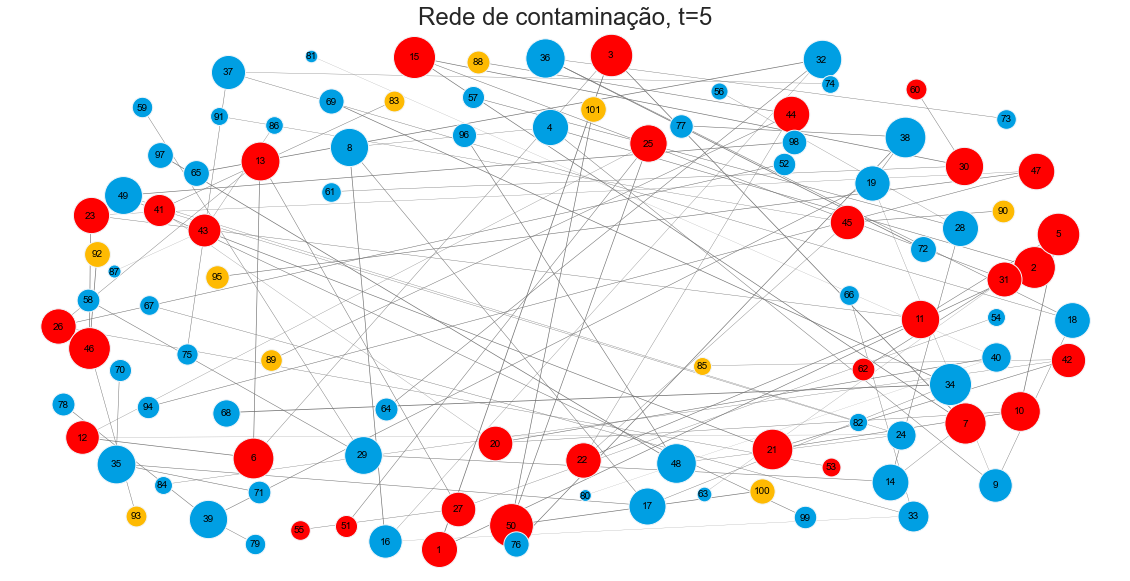

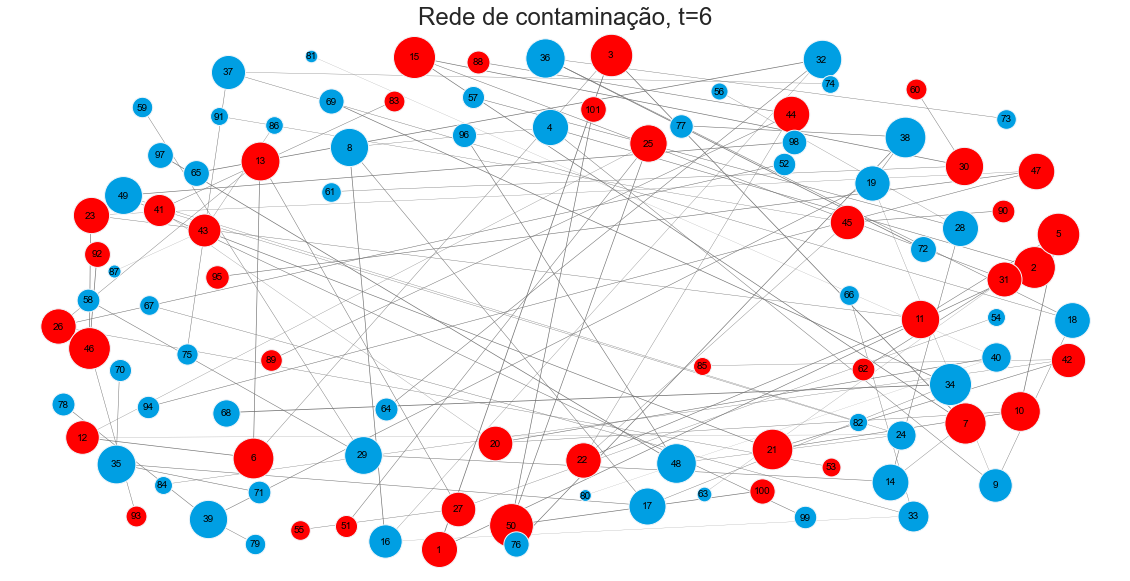

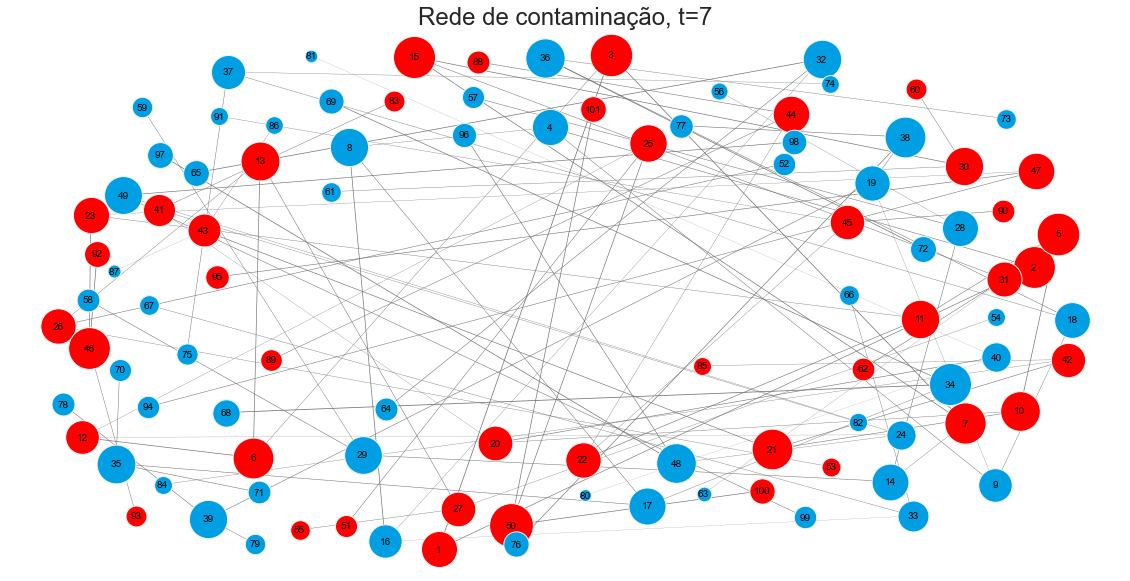

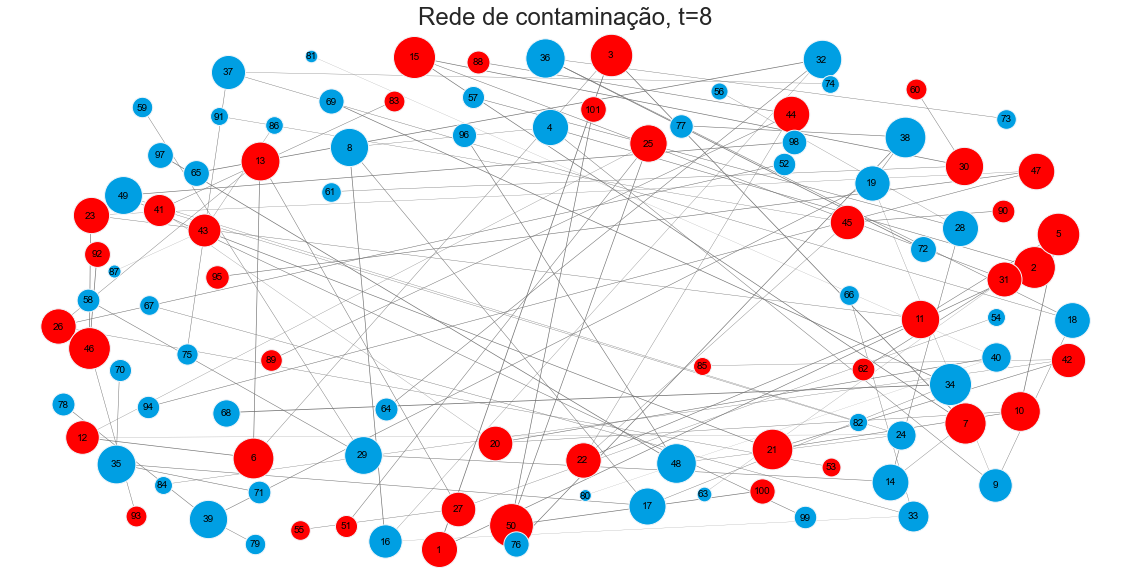

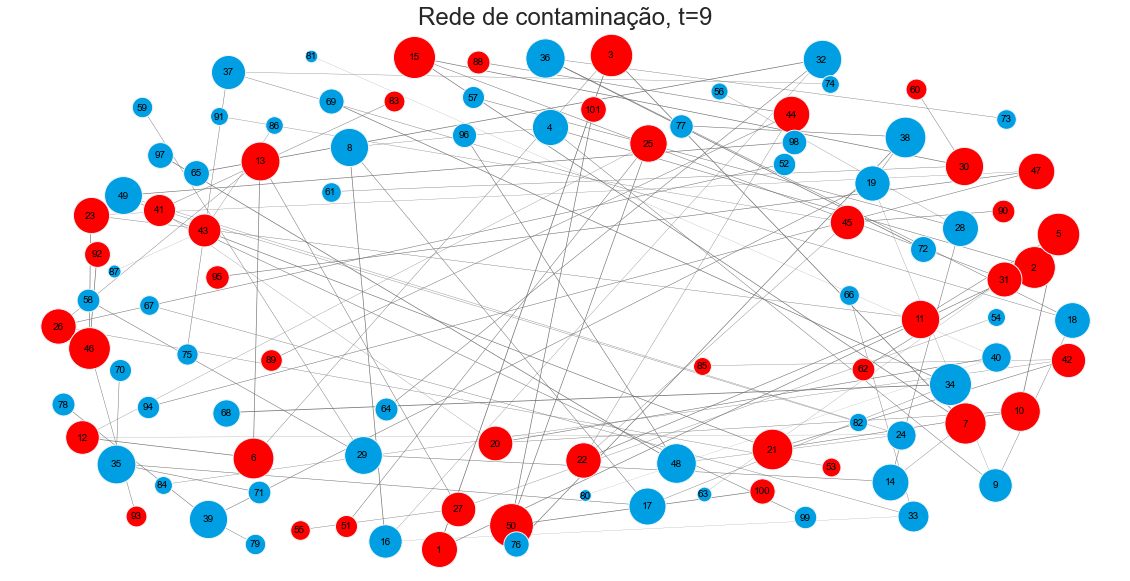

In [236]:
for t in range(10):
    plot_G(G, pos, weighted_degrees, tempo_contaminacao, t)
    tempo_contaminacao = independent_cascade(G,t,tempo_contaminacao)